Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/testing

--- Text Only Model Performance ---
              precision    recall  f1-score   support

    Negative       1.00      0.02      0.04        51
     Neutral       0.85      1.00      0.92       512
    Positive       0.00      0.00      0.00        43

   micro avg       0.85      0.85      0.85       606
   macro avg       0.62      0.34      0.32       606
weighted avg       0.80      0.85      0.78       606
 samples avg       0.85      0.85      0.85       606


--- Text + Hashtags + Mentions Model Performance ---
              precision    recall  f1-score   support

    Negative       1.00      0.02      0.04        51
     Neutral       0.85      1.00      0.92       512
    Positive       0.00      0.00      0.00        43

   micro avg       0.85      0.85      0.85       606
   macro avg       0.62      0.34      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

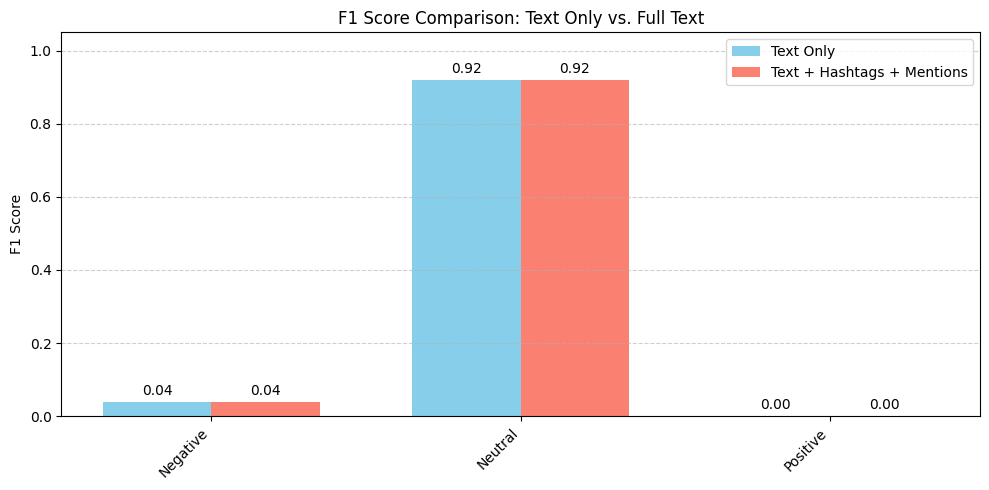

Sentiment label counts in test set:
[ 51. 512.  43.]
Sentiment label counts in predictions (Text Only):
[  1. 603.   0.]
Sentiment label counts in predictions (Full Text):
[  1. 601.   0.]


In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import OneHotEncoder

from google.colab import drive
drive.mount('/content/drive/')

# Load dataset
%cd /content/drive/MyDrive/testing/
df_ccus = pd.read_csv("/content/drive/MyDrive/testing/CCUS_Clean_dataset")

# --- 1. Clean Tweets ---
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r"[^a-zA-Z0-9@#\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

df_ccus["clean_text"] = df_ccus["Tweet"].apply(clean_tweet)
df_ccus["hashtags"] = df_ccus["Tweet"].apply(lambda x: ' '.join(re.findall(r"#\w+", str(x))))
df_ccus["mentions"] = df_ccus["Tweet"].apply(lambda x: ' '.join(re.findall(r"@\w+", str(x))))
df_ccus["full_text"] = df_ccus["clean_text"] + " " + df_ccus["hashtags"] + " " + df_ccus["mentions"]

# --- 2. One-hot encode Sentiment labels ---
sentiment_col = ["Sentiment"]
sentiment_encoder = OneHotEncoder(sparse_output=False)
sentiment_onehot = sentiment_encoder.fit_transform(df_ccus[sentiment_col])

# --- 3. Define inputs and targets ---
X_text_only = df_ccus["clean_text"]
X_text_full = df_ccus["full_text"]
Y_all = sentiment_onehot  # Only sentiment now

# --- 4. Train/test split ---
X_text_only_train, X_text_only_test, X_text_full_train, X_text_full_test, y_train, y_test = train_test_split(
    X_text_only, X_text_full, Y_all, test_size=0.2, random_state=42, stratify=df_ccus["Sentiment"]
)

# --- 5. TF-IDF Vectorization ---
tfidf = TfidfVectorizer(max_features=5000)
X_text_only_train_vec = tfidf.fit_transform(X_text_only_train)
X_text_only_test_vec = tfidf.transform(X_text_only_test)

X_text_full_train_vec = tfidf.fit_transform(X_text_full_train)
X_text_full_test_vec = tfidf.transform(X_text_full_test)

# --- 6. Build and train models ---
model_text_only = MultiOutputClassifier(LogisticRegression(max_iter=1000))
model_text_only.fit(X_text_only_train_vec, y_train)

model_text_full = MultiOutputClassifier(LogisticRegression(max_iter=1000))
model_text_full.fit(X_text_full_train_vec, y_train)

# --- 7. Predictions ---
y_pred_text_only = model_text_only.predict(X_text_only_test_vec)
y_pred_text_full = model_text_full.predict(X_text_full_test_vec)

# --- 8. Evaluation ---
sentiment_labels = sentiment_encoder.categories_[0]

print("\n--- Text Only Model Performance ---")
print(classification_report(y_test, y_pred_text_only, target_names=sentiment_labels))

print("\n--- Text + Hashtags + Mentions Model Performance ---")
print(classification_report(y_test, y_pred_text_full, target_names=sentiment_labels))

# --- 9. Plot F1 scores ---
f1_text_only = f1_score(y_test, y_pred_text_only, average=None)
f1_text_full = f1_score(y_test, y_pred_text_full, average=None)

x = np.arange(len(sentiment_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, f1_text_only, width, label='Text Only', color='skyblue')
bars2 = ax.bar(x + width/2, f1_text_full, width, label='Text + Hashtags + Mentions', color='salmon')

ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison: Text Only vs. Full Text')
ax.set_xticks(x)
ax.set_xticklabels(sentiment_labels, rotation=45, ha="right")
ax.set_ylim(0, 1.05)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 10. Print Label Distributions ---
print("Sentiment label counts in test set:")
print(np.sum(y_test, axis=0))

print("Sentiment label counts in predictions (Text Only):")
print(np.sum(y_pred_text_only, axis=0))

print("Sentiment label counts in predictions (Full Text):")
print(np.sum(y_pred_text_full, axis=0))


In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert one-hot encoded labels back to class indices
y_true_sentiment = np.argmax(y_test, axis=1)
y_pred_sentiment_text_only = np.argmax(y_pred_text_only, axis=1)
y_pred_sentiment_text_full = np.argmax(y_pred_text_full, axis=1)

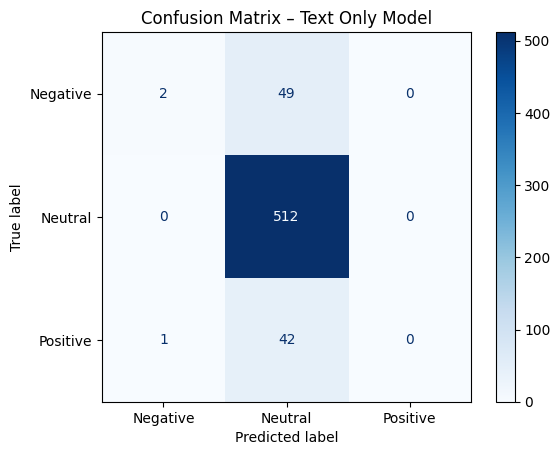

In [6]:
# Text Only Model
cm_text_only = confusion_matrix(y_true_sentiment, y_pred_sentiment_text_only)
disp_text_only = ConfusionMatrixDisplay(confusion_matrix=cm_text_only, display_labels=sentiment_labels)
disp_text_only.plot(cmap="Blues")
plt.title("Confusion Matrix – Text Only Model")
plt.grid(False)
plt.show()

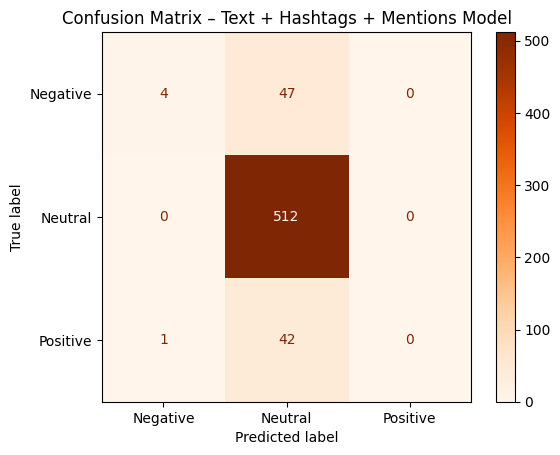

In [7]:
# Full Text Model
cm_text_full = confusion_matrix(y_true_sentiment, y_pred_sentiment_text_full)
disp_text_full = ConfusionMatrixDisplay(confusion_matrix=cm_text_full, display_labels=sentiment_labels)
disp_text_full.plot(cmap="Oranges")
plt.title("Confusion Matrix – Text + Hashtags + Mentions Model")
plt.grid(False)
plt.show()